# Video: Computing the Mean Variance Efficient Frontier

This video will show you how to compute a mean variance efficient frontier in Python from a risk model using the CVXPY library.


Script:
* Given a risk model, it is easy to compute the minimum risk portfolio, the maximum return portfolio, and all the efficient portfolios in between.
* I will show you how to do this now using the CVXPY library for the optimizations.

In [ ]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

historical_prices_url = "https://raw.githubusercontent.com/bu-cds-omds/dx704-examples/refs/heads/main/data/prices-monthly.tsv"
historical_prices = pd.read_csv(historical_prices_url, sep="\t")
historical_prices = historical_prices.set_index("date")

historical_returns = historical_prices.pct_change().dropna()
estimated_returns = historical_returns.mean().rename("return")
estimated_variances = historical_returns.var()

estimated_covariance = historical_returns.cov()

Script:
* I have already loaded up the historical data and prepared the risk return model.
* The first thing we need to do is compute the minimum risk portfolio to establish the minimum return on the efficient frontier.

In [ ]:
# minimum risk portfolio

n = len(estimated_returns)

x_minimum_risk = cp.Variable(n)

objective_minimum_risk = cp.Minimize(x_minimum_risk.T @ estimated_covariance.to_numpy() @ x_minimum_risk)
objective_minimum_risk

prob_minimum_risk = cp.Problem(objective_minimum_risk,
                               [0 <= x_minimum_risk,
                                cp.sum(x_minimum_risk) == 1])

covariance_minimum_risk = prob_minimum_risk.solve()
covariance_minimum_risk

estimated_return_minimum_risk = x_minimum_risk.value.T @ estimated_returns
estimated_return_minimum_risk


Script:
* For the maximum return on the efficient frontier, we can compute the maximum return portfolio.
* But since we do not have any extra constraints, we can just use the maximum asset return.

In [ ]:
estimated_return_maximum_return = max(estimated_returns)

Script:
* Now, I will write a loop creating optimized portfolios with different target returns from the minimum risk return to the maximum asset return.
* I will create 1000 portfolios across this range of returns so that the following charts look smooth.
* This will take about 10 seconds.

In [ ]:
ef_variances = []
ef_returns = []
ef_portfolios = []

for r in np.linspace(estimated_return_minimum_risk, max(estimated_returns), 1000):
    # create variables to optimize
    x_r = cp.Variable(n)

    # formulate linear program
    prob_r = cp.Problem(cp.Minimize(x_r.T @ estimated_covariance.to_numpy() @ x_r),
                        [0 <= x_r,
                         cp.sum(x_r) == 1,
                         x_r.T @ estimated_returns == r])
    ef_variances.append(prob_r.solve())
    ef_returns.append(r)
    ef_portfolios.append(x_r.value)

ef_portfolios = np.asarray(ef_portfolios)


Script:
* Now let's look at these efficient portfolios in risk return space and compare to the individual assets.

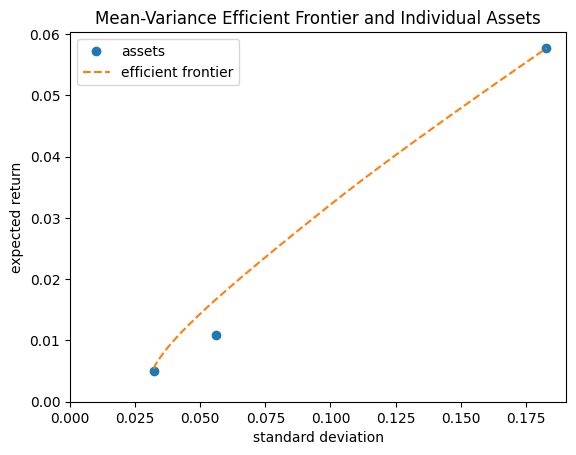

In [ ]:
plt.plot(np.sqrt(estimated_variances), estimated_returns, label="assets", linestyle="none", marker="o")
plt.plot(np.sqrt(ef_variances), ef_returns, label="efficient frontier", linestyle="--")

plt.legend()
plt.title("Mean-Variance Efficient Frontier and Individual Assets")
plt.xlabel("standard deviation")
plt.xlim(0)
plt.ylabel("expected return")
plt.ylim(0)

plt.show();

Script:
* The efficient frontier starts close to the minimum risk asset, but has slightly higher return.
* If we zoomed in, we would also see that it has slightly lower risk too.
* At the other end, the efficient frontier ends at the maximum return asset.
* And in between, we see a slight curve interpolating between the ends of the efficient frontier.
* For a given level of risk, the return is slightly better than drawing a line between the endpoints.
* And the line is above all the individual assets except the maximum return asset.
* Let's look at how the assets are allocated in these efficient portfolios.

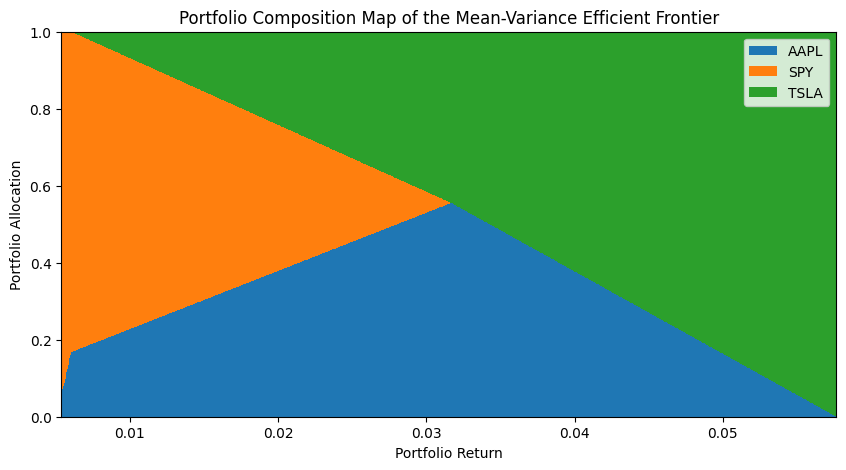

In [ ]:
plt.figure(figsize=(10, 5))

bottom = np.zeros(ef_portfolios.shape[0])
for (i, a) in enumerate(historical_returns.columns):
    plt.bar(x=ef_returns,
            height=ef_portfolios[:,i],
            bottom=bottom,
            label=a,
            width=(ef_returns[1] - ef_returns[0]))
    bottom += ef_portfolios[:,i]

plt.legend()
plt.xlabel("Portfolio Return")
plt.xlim(min(ef_returns), max(ef_returns))
plt.ylabel("Portfolio Allocation")
plt.ylim(0, 1)
plt.title("Portfolio Composition Map of the Mean-Variance Efficient Frontier")

plt.show();

Script:
* This view is called a portfolio composition map.
* It is interesting that it has three distinct regions dividing by portfolio return.
* In the first brief phase, Apple slowly replaces the S&P 500.
* In the second phase, Tesla also starts replacing the S&P 500 too.
* And in the third phase, there is no more S&P 500 and Tesla is replacing Apple.
* The transitions between these phases are triggered by constraints changing from binding to not binding or vice versa.
* In this case, the first phase transition was from Tesla being limited to zero to being allocated.
* And the second phase transition was from the S&P 500 fund hitting zero and no longer decreasing.
* Each phase corresponds to achieving the best possible tradeoffs given a set of binding constraints, and every portfolio composition map will show these phases.
* Pretty neat?

https://github.com/bu-cds-omds/dx704-examples/blob/main/week01/video_computing_the_mean_variance_efficient_frontier.ipynb